In [2]:
import math, shutil, os, time, argparse
import numpy as np
import scipy.io as sio

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from ITrackerData import ITrackerData
from ITrackerModel import ITrackerModel

import matplotlib.pyplot as plt

In [5]:
workers = 16
epochs = 25
batch_size = torch.cuda.device_count()*100 # Change if out of cuda memory

base_lr = 0.0001
momentum = 0.9
weight_decay = 1e-4
print_freq = 10
prec1 = 0
best_prec1 = 1e20
lr = base_lr

count_test = 0
count = 0

In [6]:
def train(train_loader, model, criterion,optimizer, epoch):
    global count
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()

    for i, (row, imFace, imEyeL, imEyeR, faceGrid, gaze) in enumerate(train_loader):
        
        # measure data loading time
        data_time.update(time.time() - end)
        imFace = imFace.cuda()
        imEyeL = imEyeL.cuda()
        imEyeR = imEyeR.cuda()
        faceGrid = faceGrid.cuda()
        gaze = gaze.cuda()
        
        imFace = torch.autograd.Variable(imFace, requires_grad = True)
        imEyeL = torch.autograd.Variable(imEyeL, requires_grad = True)
        imEyeR = torch.autograd.Variable(imEyeR, requires_grad = True)
        faceGrid = torch.autograd.Variable(faceGrid, requires_grad = True)
        gaze = torch.autograd.Variable(gaze, requires_grad = False)

        # compute output
        output = model(imFace, imEyeL, imEyeR, faceGrid)

        loss = criterion(output, gaze)
        
        losses.update(loss.data.item(), imFace.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        count=count+1

        print('Epoch (train): [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))

def validate(val_loader, model, criterion, epoch):
    global count_test
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    lossesLin = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()


    oIndex = 0
    for i, (row, imFace, imEyeL, imEyeR, faceGrid, gaze) in enumerate(val_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        imFace = imFace.cuda()
        imEyeL = imEyeL.cuda()
        imEyeR = imEyeR.cuda()
        faceGrid = faceGrid.cuda()
        gaze = gaze.cuda()
        
        imFace = torch.autograd.Variable(imFace, requires_grad = False)
        imEyeL = torch.autograd.Variable(imEyeL, requires_grad = False)
        imEyeR = torch.autograd.Variable(imEyeR, requires_grad = False)
        faceGrid = torch.autograd.Variable(faceGrid, requires_grad = False)
        gaze = torch.autograd.Variable(gaze, requires_grad = False)

        # compute output
        with torch.no_grad():
            output = model(imFace, imEyeL, imEyeR, faceGrid)

        loss = criterion(output, gaze)
        
        lossLin = output - gaze
        lossLin = torch.mul(lossLin,lossLin)
        lossLin = torch.sum(lossLin,1)
        lossLin = torch.mean(torch.sqrt(lossLin))

        losses.update(loss.data.item(), imFace.size(0))
        lossesLin.update(lossLin.item(), imFace.size(0))
     
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()


        print('Epoch (val): [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Error L2 {lossLin.val:.4f} ({lossLin.avg:.4f})\t'.format(
                    epoch, i, len(val_loader), batch_time=batch_time,
                   loss=losses,lossLin=lossesLin))

    return lossesLin.avg

CHECKPOINTS_PATH = '.'

def load_checkpoint(filename='best_checkpoint.pth.tar'):
    filename = os.path.join(CHECKPOINTS_PATH, filename)
    print(filename)
    if not os.path.isfile(filename):
        return None
    state = torch.load(filename)
    return state

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    if not os.path.isdir(CHECKPOINTS_PATH):
        os.makedirs(CHECKPOINTS_PATH, 0o777)
    bestFilename = os.path.join(CHECKPOINTS_PATH, 'best_' + filename)
    filename = os.path.join(CHECKPOINTS_PATH, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, bestFilename)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = base_lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.state_dict()['param_groups']:
        param_group['lr'] = lr

In [7]:
global args, best_prec1, weight_decay, momentum

model = ITrackerModel()
model = torch.nn.DataParallel(model)
model.cuda()
imSize=(224,224)
cudnn.benchmark = True   

epoch = 0

In [8]:
doLoad = True
doTest = True
data_path = '../../datasets/prepared'

In [9]:
if doLoad:
    saved = load_checkpoint()
    if saved:
        print('Loading checkpoint for epoch %05d with loss %.5f (which is the mean squared error not the actual linear error)...' % (saved['epoch'], saved['best_prec1']))
        state = saved['state_dict']
        try:
            model.module.load_state_dict(state)
        except:
            model.load_state_dict(state)
        epoch = saved['epoch']
        best_prec1 = saved['best_prec1']
    else:
        print('Warning: Could not read checkpoint!')

./best_checkpoint.pth.tar
Loading checkpoint for epoch 00025 with loss 2.43143 (which is the mean squared error not the actual linear error)...


DataParallel(
  (module): ITrackerModel(
    (eyeModel): ItrackerImageModel(
      (features): Sequential(
        (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1.0)
        (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1.0)
        (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU(inplace=True)
        (10): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1))
        (11): ReLU(inplace=True)
      )
    )
    (faceModel): FaceImageModel(
      (conv): ItrackerImageModel(
        (features): Sequential(
          (0): Conv2d(3, 96, kernel_size=(11, 11), 

In [10]:
dataTrain = ITrackerData(dataPath = data_path, split='train', imSize = imSize)
dataVal = ITrackerData(dataPath = data_path, split='val', imSize = imSize)
# dataTest = ITrackerData(dataPath = data_path, split='test', imSize = imSize)

train_loader = torch.utils.data.DataLoader(
    dataTrain,
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=True)

# test_loader = torch.utils.data.DataLoader(
#     dataTest,
#     batch_size=batch_size, shuffle=False,
#     num_workers=workers, pin_memory=True)

criterion = nn.MSELoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

Loading iTracker dataset...


RuntimeError: There is no such file ../../datasets/prepared/metadata.mat! Provide a valid dataset path.

In [11]:
val_loader = torch.utils.data.DataLoader(
    dataVal,
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=True)


NameError: name 'dataVal' is not defined

In [10]:
# # Quick test
# if doTest:
#     validate(val_loader, model, criterion, epoch)
# else:
#     for epoch in range(0, epoch):
#         adjust_learning_rate(optimizer, epoch)

#     for epoch in range(epoch, epochs):
#         adjust_learning_rate(optimizer, epoch)

#         # train for one epoch
#         train(train_loader, model, criterion, optimizer, epoch)

#         # evaluate on validation set
#         prec1 = validate(val_loader, model, criterion, epoch)

#         # remember best prec@1 and save checkpoint
#         is_best = prec1 < best_prec1
#         best_prec1 = min(prec1, best_prec1)
#         save_checkpoint({
#             'epoch': epoch + 1,
#             'state_dict': model.state_dict(),
#             'best_prec1': best_prec1,
#         }, is_best)

In [14]:
def show_results(img_face, img_leye, img_reye, gaze, output):
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(3,3,(2,2))
    ax1.imshow(img_face.permute(1, 2, 0).cpu())
    ax2 = fig.add_subplot(3,3,3)
    ax2.imshow(img_reye.permute(1, 2, 0).cpu())
    ax3 = fig.add_subplot(3,3,6)
    ax3.imshow(img_leye.permute(1, 2, 0).cpu())
    
    # Plot gaze vectors
    ax4 = fig.add_subplot(3,3,5)
    gaze = np.array(gaze.cpu())
    output = np.array(output.cpu())
#     gaze = np.array(gaze)
#     output = np.array(output)
#     origin = np.array([0,0])
    V = np.array([gaze, output])
    origin = np.array([[0, 0],[0, 0]]) # origin point

    q_handle = ax4.quiver(*origin, gaze[0], gaze[1], color='r', angles='xy', scale_units='xy', scale=1, label='True')
    q_handle = ax4.quiver(*origin, output[0], output[1], color='b', angles='xy', scale_units='xy', scale=1, label='Prediction')
    ax4.set_xlim([-20,20])
    ax4.set_ylim([-20,20])

    ax4.legend()
#     ax4.quiverkey(q_handle, 1.2, 0.515, 2, ['arrow 1', 'output'])
#     plt.show()



In [19]:
def run_inference_first_batch(val_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    lossesLin = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    
    eval_metrics = {
        'cur_time': [],
        'avg_time': [],
        'cur_err': [],
        'avg_err': []
    }
    
    for i, (row, imFace, imEyeL, imEyeR, faceGrid, gaze) in enumerate(val_loader):
        imFace = imFace.cuda()
        imEyeL = imEyeL.cuda()
        imEyeR = imEyeR.cuda()
        faceGrid = faceGrid.cuda()
        gaze = gaze.cuda()

        imFace = torch.autograd.Variable(imFace, requires_grad = False)
        imEyeL = torch.autograd.Variable(imEyeL, requires_grad = False)
        imEyeR = torch.autograd.Variable(imEyeR, requires_grad = False)
        faceGrid = torch.autograd.Variable(faceGrid, requires_grad = False)
        gaze = torch.autograd.Variable(gaze, requires_grad = False)

        # compute output
        with torch.no_grad():
            output = model(imFace, imEyeL, imEyeR, faceGrid)

        loss = criterion(output, gaze)
        
        lossLin = output - gaze
        lossLin = torch.mul(lossLin,lossLin)
        lossLin = torch.sum(lossLin,1)
        lossLin = torch.mean(torch.sqrt(lossLin))

        losses.update(loss.data.item(), imFace.size(0))
        lossesLin.update(lossLin.item(), imFace.size(0))
     
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        epoch = 25
        
        print('Epoch (val): [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Error L2 {lossLin.val:.4f} ({lossLin.avg:.4f})\t'.format(
                    epoch, i, len(val_loader), batch_time=batch_time,
                   loss=losses,lossLin=lossesLin))
        
        eval_metrics['cur_time'].append(batch_time.val)
        eval_metrics['avg_time'].append(batch_time.avg)
        eval_metrics['cur_err'].append(lossesLin.val)
        eval_metrics['avg_err'].append(lossesLin.avg)
#         break
    
    return (row, imFace, imEyeL, imEyeR, faceGrid, gaze, output, eval_metrics)

In [21]:
row, imFace, imEyeL, imEyeR, faceGrid, gaze, output, eval_metrics = run_inference_first_batch(val_loader, model, criterion)

NameError: name 'val_loader' is not defined

In [20]:
print(min(batch_time))
print(min(batch_err))
print(max(batch_time))
print(max(batch_err))

NameError: name 'batch_time' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-0.0865   -3.716244]
tensor([-0.4140, -5.5215])


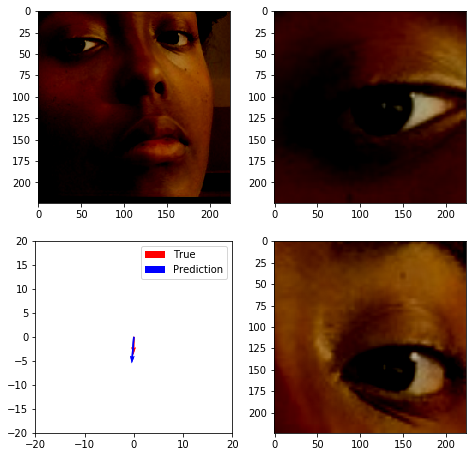

In [26]:
imIdx = 57

imFace_ = imFace[imIdx, :, :, :]
imEyeL_ = imEyeL[imIdx, :, :, :]
imEyeR_ = imEyeR[imIdx, :, :, :]
gaze_ = gaze[imIdx, :]
output_ = output[imIdx, :]
print(np.array(gaze_.cpu()))
print(output_.cpu())
imFace_.shape
show_results(imFace_, imEyeL_, imEyeR_, gaze_, output_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


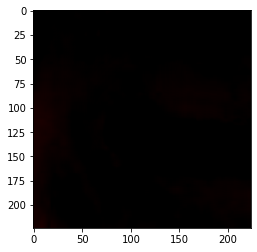

In [59]:
plt.imshow(imEyeL.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


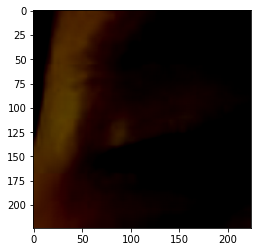

In [60]:
plt.imshow(imEyeR.permute(1, 2, 0))